This works really well! Tomorrow, first thing, is to upload to GitHub! 

Then, I will try to change my model to overriide the train_step and test_step functions as explained here: 

https://www.tensorflow.org/guide/keras/customizing_what_happens_in_fit

Then I can just run model.compile and model.fit! I can also easily add things like early stopping

In [1]:
import numpy as np
import tensorflow as tf
import graph_nets as gn
import sonnet as snt
import matplotlib.pyplot as plt

Global Constants

In [2]:
# Global constants
DAY = 24*3600. # Day in seconds
YEAR = 365.25*DAY #Year
delta_time = (2/24.)*DAY/YEAR # 1 hour
MSUN = 1.98892e+30
MEARTH = 5.9742e+24

Helper functions

In [3]:
#def shuffle_data(X):
#    indices = np.random.permutation(np.arange(len(X)))
#    Y = np.empty(X.shape)
#    for i in range(len(X)):
#        Y[i] = X[indices[i]]       
#    return Y

def reshape_senders_receivers(senders, receivers, batch_size, nplanets, nedges):
    ''' Reshape receivers and senders to use in graph'''
    x = np.arange(batch_size)
    xx = x.reshape(batch_size,1)
    y = np.ones(nedges)
    z = np.reshape(xx+y-1, batch_size*nedges)*nplanets

    senders = np.concatenate([senders]*batch_size) + z
    receivers = np.concatenate([receivers]*batch_size) + z
    
    return senders, receivers

Training variables

In [4]:
# Training variables
batch_size_tr = 75
patience = 5
d_patience = 0
noise_level = 0.05
log_every_iterations = 1000
num_training_iterations = 200000

# Do not change this
total_time_traj = 20 #Years
num_time_steps_total = int(total_time_traj/delta_time)
num_time_steps_tr = 75000 
#num_time_steps_val = int(total_time_traj/delta_time) - num_time_steps_tr

Read the data

In [5]:
orbit_sun = np.loadtxt('nasa_orbits/sun_center/sun.txt', usecols = [2,3,4, 5, 6, 7], unpack=True, delimiter=',')
orbit_mercury = np.loadtxt('nasa_orbits/sun_center/mercury.txt', usecols = [2,3,4, 5, 6, 7], unpack=True, delimiter=',')
orbit_venus = np.loadtxt('nasa_orbits/sun_center/venus.txt', usecols = [2,3,4, 5, 6, 7], unpack=True, delimiter=',')

In [6]:
masses = np.array([MSUN/MEARTH, 
          0.33011 * 10**24/MEARTH,
          4.8685 * 10**24/MEARTH
          ])

nplanets = len(masses)
nedges = nplanets*(nplanets-1)//2

In [7]:
data = np.stack([orbit_sun, 
                 orbit_mercury, 
                 orbit_venus,
                ])
data = data.transpose(2,0,1)

# Change frame of reference to the barycenter of the planets we are using
P = masses[np.newaxis, :, np.newaxis]*data[:,:,3:]
V_ref = np.sum(P, axis = 1,keepdims=True)/np.sum(masses)
data[:,:,3:] -= V_ref

A = data[1:,:,3:] - data[:-1,:,3:]
data[:-1, :, 3:] = A 
data = data[:-1]

# Split into training and validation
data_tr = data[:num_time_steps_tr]
data_val = data[num_time_steps_tr:]

num_time_steps_val = len(data_val)

# Shuffle the data
np.random.shuffle(data_tr)
np.random.shuffle(data_val)

D_tr = np.empty([len(data_tr), nedges, 3])
D_val = np.empty([len(data_val), nedges, 3])
k=0
senders, receivers = [], []
for i in range(nplanets):
    for j in range(nplanets):
        if i > j:
            d_tr = data_tr[:,j,:3] - data_tr[:,i,:3]
            d_val = data_val[:,j,:3] - data_val[:,i,:3]
            D_tr[:,k,:] = d_tr#cartesian_to_spherical_coordinates(d_tr)
            D_val[:,k,:] = d_val #cartesian_to_spherical_coordinates(d_val)
            
            k+=1 
            receivers.append(i)
            senders.append(j)

A_tr = data_tr[:,:,3:]
A_val = data_val[:,:,3:]
A_norm =np.std(A_tr) 

D_tr_flat = tf.reshape(D_tr[:,:,:], shape = [num_time_steps_tr*nedges, 3])
num_time_steps_val = len(A_val)
D_val_flat = tf.reshape(D_val[:,:,:], shape = [num_time_steps_val*nedges, 3])

D_tr = tf.convert_to_tensor(D_tr_flat)
A_tr = tf.convert_to_tensor(A_tr/A_norm)
D_tr_batches = tf.split(D_tr,  1000)
A_tr_batches = tf.split(A_tr,  1000)

D_val = tf.convert_to_tensor(D_val[:-1,:,:])
A_val = tf.convert_to_tensor(A_val/A_norm)

nodes_tr = np.concatenate([np.log(masses)]*batch_size_tr)[:,np.newaxis]
nodes_val = np.concatenate([np.log(masses)]*num_time_steps_val)[:,np.newaxis]

senders_tr, receivers_tr = reshape_senders_receivers(senders, receivers, batch_size_tr, nplanets, nedges)
senders_val, receivers_val = reshape_senders_receivers(senders, receivers, num_time_steps_val, nplanets, nedges)

In [8]:
#nplanets, _, ntime = X.shape
class LearnForces(tf.keras.Model):
    def __init__(self):
        super(LearnForces, self).__init__()
        self.nplanets = nplanets
        
        #m_init = tf.random_normal_initializer()
        #self.m = tf.Variable(
        #    initial_value=m_init(shape=(self.nplanets,), dtype="float32"),
        #    trainable=True,
        #)
        
        self.graph_network = gn.blocks.EdgeBlock(
            #edge_model_fn=lambda: snt.Linear(output_size=3),
            edge_model_fn=lambda: snt.nets.MLP([32, 32, 3]), 
            use_edges = True,
            use_receiver_nodes = True,
            use_sender_nodes = True,
            use_globals = False,
        )

    def sum_forces(self, graph):
        b1_tr = gn.blocks.ReceivedEdgesToNodesAggregator(reducer = tf.math.unsorted_segment_sum)(graph)
        b2_tr = gn.blocks.SentEdgesToNodesAggregator(reducer = tf.math.unsorted_segment_sum)(graph)
        summed_forces = b1_tr-b2_tr
        return summed_forces
            
    def get_acceleration(self, forces, graph):
        acceleration_tr = tf.divide(forces, tf.exp(graph.nodes))
        output_ops_tr = tf.reshape(acceleration_tr, shape=[self.ntime, self.nplanets, 3])
        return output_ops_tr
        
    def call(self, g):
        self.ntime = len(g.nodes)//nplanets
        g = self.graph_network(g)
        f = self.sum_forces(g)
        a = self.get_acceleration(f, g)
        return a


In [9]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
loss_fn = tf.keras.losses.MeanAbsoluteError()

train_loss = tf.keras.metrics.Mean(name='train_loss')
test_loss = tf.keras.metrics.MeanAbsoluteError(name='test_loss')

model = LearnForces()

In [10]:
@tf.function
def train_step(D, A):

    graph_dict = { 
          "nodes": nodes_tr,
          "edges": D, 
          "receivers": receivers_tr, 
          "senders": senders_tr 
           } 
    
    g = gn.utils_tf.data_dicts_to_graphs_tuple([graph_dict])
    
    with tf.GradientTape() as tape:
        predictions = model(g)
        loss = loss_fn(A, predictions)
    gradients = tape.gradient(loss, model.graph_network.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.graph_network.trainable_variables))

    train_loss(loss)

In [11]:
@tf.function
def test_step(D, A):
    graph_dict = { 
          "nodes": nodes_val,
          "edges": D, 
          "receivers": receivers_val,
          "senders": senders_val 
           } 
    
    g = gn.utils_tf.data_dicts_to_graphs_tuple([graph_dict])
    
    predictions = model(g)

    test_loss(A, predictions)

In [12]:
EPOCHS = 200

for epoch in range(EPOCHS):
    # Reset the metrics at the start of the next epoch
    train_loss.reset_states()
    test_loss.reset_states()

    for images, labels in zip(D_tr_batches, A_tr_batches):
        train_step(images, labels)

    
    test_step(D_val_flat, A_val)

    print(
        f'Epoch {epoch + 1}, '
        f'Loss: {train_loss.result()}, '
        f'Test Loss: {test_loss.result()}, '
  )

Epoch 1, Loss: 0.28060176968574524, Test Loss: 0.18375995755195618, 
Epoch 2, Loss: 0.18796057999134064, Test Loss: 0.13913562893867493, 
Epoch 3, Loss: 0.15799008309841156, Test Loss: 0.14879578351974487, 
Epoch 4, Loss: 0.11870390176773071, Test Loss: 0.10613763332366943, 
Epoch 5, Loss: 0.10328705608844757, Test Loss: 0.12367016077041626, 
Epoch 6, Loss: 0.11478692293167114, Test Loss: 0.08180970698595047, 
Epoch 7, Loss: 0.10861177742481232, Test Loss: 0.06721899658441544, 
Epoch 8, Loss: 0.10144142061471939, Test Loss: 0.11977587640285492, 
Epoch 9, Loss: 0.09304135292768478, Test Loss: 0.07711447030305862, 
Epoch 10, Loss: 0.08120410144329071, Test Loss: 0.05936294049024582, 
Epoch 11, Loss: 0.06635263562202454, Test Loss: 0.04915495216846466, 
Epoch 12, Loss: 0.06483232975006104, Test Loss: 0.035514120012521744, 
Epoch 13, Loss: 0.06003820151090622, Test Loss: 0.09069428592920303, 
Epoch 14, Loss: 0.06572110950946808, Test Loss: 0.03403957188129425, 
Epoch 15, Loss: 0.0571788027

KeyboardInterrupt: 

In [13]:
graph_dict = { 
          "nodes": nodes_val,
          "edges": D_val_flat, 
          "receivers": receivers_val,
          "senders": senders_val 
           } 
    
g = gn.utils_tf.data_dicts_to_graphs_tuple([graph_dict])
    
A_pred =  model(g)



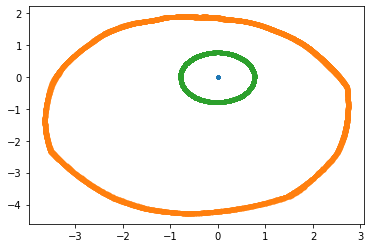

In [14]:
plt.plot(A_pred[:,:,0], A_pred[:,:,1], '.')

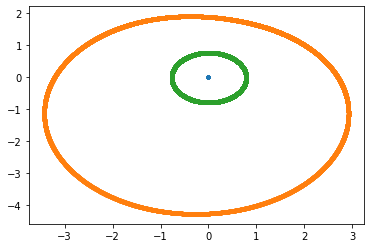

In [15]:
plt.plot(A_val[:,:,0], A_val[:,:,1], '.')

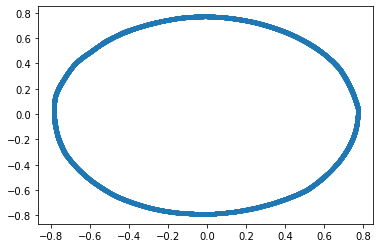

In [16]:
plt.plot(A_pred[:,2,0], A_pred[:,2,1], '.')

In [ ]:
x = np.arange(batch_size_tr)
xx = x.reshape(batch_size_tr,1)
y = np.ones(nedges)
z = np.reshape(xx+y-1, batch_size_tr*nedges)*nplanets

In [ ]:
z

In [ ]:
plt.plot(D_tr_flat[-10:,0], D_tr_flat[-10:,1], '.')

In [ ]:
plt.plot(A_tr[-10:,1,0], A_tr[-10:,1,1], '.')

In [ ]:
masses

In [ ]:
nodes_tr

In [ ]:
masses